# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
sample_data = filtered_data.head(350000) #Sampled amazon fine foood reviews filtered data to 50k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(256438, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

73.268

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(256436, 10)


1    215863
0     40573
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with 

In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'were', 'such', 'an', 'too', 'no', 'you', 'we', 'how', 'over', 'shouldn', 'before', 'wouldn', 'and', 'wasn', 'has', 'with', 't', 'because', "she's", 'needn', 'don', 'weren', 'was', 'ours', 'both', "mightn't", 'yourself', 'nor', "you'd", 'after', "weren't", 'mightn', 'further', 'having', 'who', 'do', 'this', 'down', 'some', 'him', 'where', 'few', "couldn't", "isn't", 'for', 'between', "don't", 'd', 'does', "needn't", 'these', 'ourselves', 'those', "shan't", "wouldn't", 'can', 'any', 'whom', 'from', 'ma', 'have', 'your', "hadn't", "you'll", "that'll", 'why', 'what', 'haven', 'y', 'against', 'its', 'during', 'off', 'they', 'my', 'did', 'if', 'while', 'above', 'but', 'o', 'all', 're', 'won', "you're", 'through', "you've", 'of', 'below', 'most', 'other', 'm', "hasn't", 'is', "aren't", 'at', 'in', 'her', 'their', 'am', 'by', 'so', 'ain', 'very', 'it', 'yours', 'that', 'me', 'doesn', 'she', 'couldn', "mustn't", 'i', 'here', 'shan', 'to', 'will', "haven't", 'didn', 'more', "didn't", 'hasn', '

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [15]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(256436, 12)

### Spliting data 

In [16]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [17]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (171812,) (171812,)
X_test, Y_test (84624,) (84624,)
X_tr, Y_tr (115114,) (115114,)
X_cv, Y_cv (56698,) (56698,)


# Logistic Regression with simple CV

In [18]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Training Model

In [19]:
from sklearn.linear_model import LogisticRegression
# logistic Regression with penality = 'l1'
def logistic_l1(X_train,X_cv,Y_train,Y_cv):
    best_C=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    C=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
    for i in C[-19:]:
        logisticl1 = LogisticRegression(C=i,penalty='l1')
        logisticl1.fit(X_train,Y_train)
        probs = logisticl1.predict_proba(X_cv)
        prob = logisticl1.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_C=i
    print(f"\n Best C Value {best_C} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(C, pred_cv,'r-', label = 'CV Data')
    plt.plot(C,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\lambda$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train,prob)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

In [20]:
# logistic Regression with penality = 'l2'
def logistic_l2(X_train,X_cv,Y_train,Y_cv):
    best_C=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    C=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
    for i in C[-19:]:
        logisticl2 = LogisticRegression(penalty='l2',C=i)
        logisticl2.fit(X_train,Y_train)
        probs = logisticl2.predict_proba(X_cv)
        prob = logisticl2.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_C=i
    print(f"\n Best C Value {best_C} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(C, pred_cv,'r-', label = 'CV Data')
    plt.plot(C,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\lambda$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train,prob)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

## Testing Model 

In [21]:
import scikitplot.metrics as skplt
def testing_l1(X_train,Y_train,X_test,Y_test,optimal_C):
    log1 = LogisticRegression(penalty='l1',C=optimal_C)
    log1.fit(X_train,Y_train)
    probs = log1.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=log1.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

In [22]:
import scikitplot.metrics as skplt
def testing_l2(X_train,Y_train,X_test,Y_test,optimal_C):
    log2 = LogisticRegression(penalty='l2',C=optimal_C)
    log2.fit(X_train,Y_train)
    prob = log2.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=np.argmax(prob,axis=1)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

## Top 10 features

In [23]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def imp_feature(vectorizer,classifier, n =10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [24]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (115114, 40518)
CV Data Size:  (56698, 40518)
Test Data Size:  (84624, 40518)


In [25]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (115114, 40518)
CV Data Size:  (56698, 40518)
Test Data Size:  (84624, 40518)


10000  for CV data auc score is -->  0.8591291509540182  and for train data auc score is -->  0.991692805764055
5000  for CV data auc score is -->  0.8656010185454268  and for train data auc score is -->  0.9916012276958703
1000  for CV data auc score is -->  0.8840879353925195  and for train data auc score is -->  0.9911459175082964
500  for CV data auc score is -->  0.8935563225669626  and for train data auc score is -->  0.9907771726334812
100  for CV data auc score is -->  0.9187618429164522  and for train data auc score is -->  0.9888837018317955
50  for CV data auc score is -->  0.9294023601730566  and for train data auc score is -->  0.9870480158687965
10  for CV data auc score is -->  0.9463781157436285  and for train data auc score is -->  0.9764085743619657
5  for CV data auc score is -->  0.9496968652597577  and for train data auc score is -->  0.9683105263652751
1  for CV data auc score is -->  0.9482992111337504  and for train data auc score is -->  0.9533979045545207
0.5 

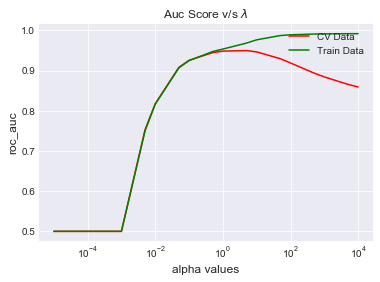

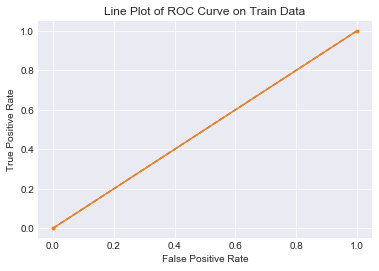

In [26]:
# find optimal C using l1 regularization 
logistic_l1(bow_train,bow_cv,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.9127841737630985  and for train data auc score is -->  0.9897281884728407
5000  for CV data auc score is -->  0.9138686158632009  and for train data auc score is -->  0.9896973422809399
1000  for CV data auc score is -->  0.927186102455792  and for train data auc score is -->  0.988041200011742
500  for CV data auc score is -->  0.9333170829735581  and for train data auc score is -->  0.9866459363697928
100  for CV data auc score is -->  0.9441792690434782  and for train data auc score is -->  0.9813658579150831
50  for CV data auc score is -->  0.947290076773607  and for train data auc score is -->  0.9781252633562354
10  for CV data auc score is -->  0.9509302358871625  and for train data auc score is -->  0.9688834001663503
5  for CV data auc score is -->  0.9510561394782234  and for train data auc score is -->  0.9647478564309291
1  for CV data auc score is -->  0.9479028478481482  and for train data auc score is -->  0.9546783935299155
0.5  f

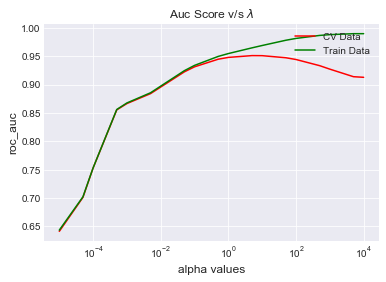

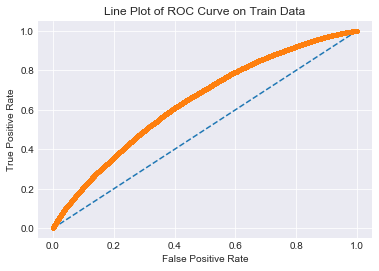

In [27]:
# find optimal C using l2 regularization 
logistic_l2(bow_train,bow_cv,Y_tr,Y_cv)

### LR simple CV Over the unseen or Test data in BoW

AUC Score 0.9484446122522991
macro f1 score for data : 0.8399401095322441
micro f1 scoore for data: 0.9203417470221213
hamming loss for data: 0.07965825297787861
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73     13407
           1       0.94      0.97      0.95     71217

   micro avg       0.92      0.92      0.92     84624
   macro avg       0.87      0.82      0.84     84624
weighted avg       0.92      0.92      0.92     84624



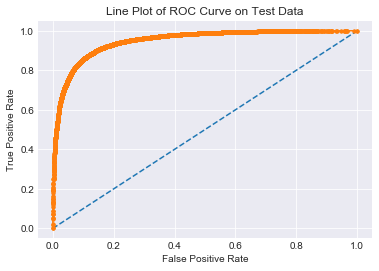

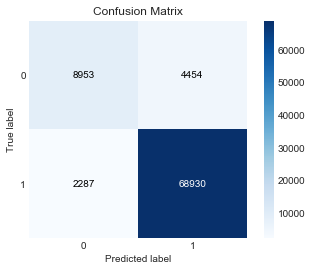

In [28]:
# optimal_C=5 for l1 regularization
testing_l1(bow_train,Y_tr,bow_test,Y_test,optimal_C=5)

AUC Score 0.950224330260219
macro f1 score for data : 0.839190542368675
micro f1 scoore for data: 0.9212043864624693
hamming loss for data: 0.07879561353753073
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.81      0.65      0.72     13407
           1       0.94      0.97      0.95     71217

   micro avg       0.92      0.92      0.92     84624
   macro avg       0.87      0.81      0.84     84624
weighted avg       0.92      0.92      0.92     84624



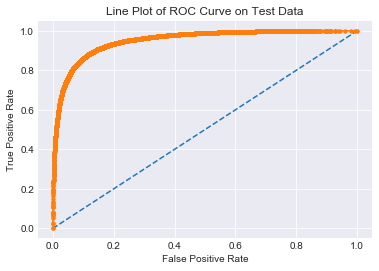

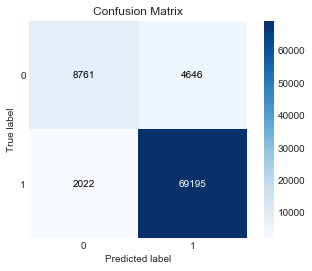

In [29]:
# optimal_C=5 for l2 regularization
testing_l2(bow_train,Y_tr,bow_test,Y_test,optimal_C=5)

In [30]:
#top 10 important feature for l1 regularization
clf1 = LogisticRegression(penalty='l1',C=5)
clf1.fit(bow_train,Y_tr)
imp_feature(count_vect,clf1)

			Negative						Positive
________________________________________________________________________________________________
	-19.7499	unpalat        				16.1082	gorgeous       
	-19.4247	undrink        				15.5464	gaug           
	-19.2795	unforun        				15.3827	downsid        
	-18.4574	worst          				14.6834	chedder        
	-17.9760	excruci        				14.5200	gentleas       
	-17.9694	instantto      				13.9197	skeptic        
	-17.8914	weruvia        				12.7032	gustaf         
	-17.8532	weakest        				12.4288	worri          
	-17.6276	glorifi        				12.2971	divin          
	-17.3093	caserol        				11.9851	fantast        


In [31]:
#top 10 important feature for l2 regularization
clf2 = LogisticRegression(penalty='l2',C=5)
clf2.fit(bow_train,Y_tr)
imp_feature(count_vect,clf2)

			Negative						Positive
________________________________________________________________________________________________
	-14.7919	worst          				9.2818	delici         
	-10.8124	terribl        				9.0009	fantast        
	-10.7348	aw             				8.8579	excel          
	-9.7915	horribl        				8.7780	perfect        
	-9.3843	yuck           				8.6811	worri          
	-9.1835	disappoint     				7.8053	amaz           
	-8.9161	disgust        				7.8032	awesom         
	-8.7790	threw          				7.7341	best           
	-8.5459	tasteless      				7.3941	beat           
	-8.4010	mediocr        				7.2527	addict         


### Sparsity using L1 Regularization

In [32]:
def sparsity(train_data,Y_train,test_data,Y_test):
    C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
    for i in C_value[-8:]:
        lr = LogisticRegression(C=i,penalty='l1')
        lr.fit(train_data,Y_train)
        pred = lr.predict(test_data)
        print("C_value = ",i ," and l1_value = l1" )
        print("roc_auc score on test set: %0.3f%%"%(roc_auc_score(Y_test,pred)*100))
        print("Non Zero weights:",np.count_nonzero(lr.coef_))
        print("=+=+"*30)

In [33]:
sparsity(bow_train,Y_tr,bow_test,Y_test)

C_value =  1000  and l1_value = l1
roc_auc score on test set: 78.711%
Non Zero weights: 20661
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  100  and l1_value = l1
roc_auc score on test set: 80.783%
Non Zero weights: 15370
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  10  and l1_value = l1
roc_auc score on test set: 81.976%
Non Zero weights: 7219
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  1  and l1_value = l1
roc_auc score on test set: 80.435%
Non Zero weights: 1470
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  0.1  and l1_value = l1
roc_auc score on test set: 72.841%
Non Zero weights: 316
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

### Pertubation Test  on BoW

In [34]:
from scipy.sparse import find
logreg1 = LogisticRegression(C= 5, penalty= 'l2')
logreg1.fit(bow_train,Y_tr)
weights1 = find(logreg1.coef_[0])[2]  #Weights before adding random noise
print("Non Zero weights:",np.count_nonzero(logreg1.coef_))

Non Zero weights: 40518


In [35]:
bow_train_noise = bow_train
#Random noise
epsilon = np.random.uniform(low=-0.00001, high=0.00001, size=(find(bow_train_noise)[0].size))
a,b,c = find(bow_train)
bow_train_noise[a,b] = epsilon + bow_train[a,b]

In [36]:
logreg2 = LogisticRegression(C= 5, penalty= 'l2')
logreg2.fit(bow_train_noise,Y_tr)
print("Non Zero weights:",np.count_nonzero(logreg2.coef_))
weights2 = find(logreg2.coef_[0])[2]  #Weights after adding random noise

Non Zero weights: 40518


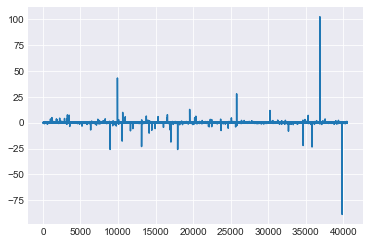

In [37]:
percentage_change_vector = (abs(weights1 - weights2)/weights1) * 100
plt.plot(percentage_change_vector)

In [38]:
print(percentage_change_vector[np.where(percentage_change_vector > 10)].size)

5


### Top 10 Collinear feature after Pertubation test

In [39]:
index = np.argsort(np.abs(weights1 - weights2))[::-1]
features = count_vect.get_feature_names()
features = np.array(features)
a = features[index]
print(a[:10])

['skeptic' 'earth' 'smooth' 'depend' 'unpleas' 'terribl' 'ruin' 'unus'
 'bustelo' 'happier']


##  TF-IDF

In [40]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (115114, 1386366)
CV Data Size:  (56698, 1386366)
Test Data Size:  (84624, 1386366)


In [41]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (115114, 1386366)
CV Data Size:  (56698, 1386366)
Test Data Size:  (84624, 1386366)


10000  for CV data auc score is -->  0.9479051433995807  and for train data auc score is -->  0.999999998860608
5000  for CV data auc score is -->  0.9510492273692229  and for train data auc score is -->  0.999999998860608
1000  for CV data auc score is -->  0.9521113410663302  and for train data auc score is -->  0.9999999988606079
500  for CV data auc score is -->  0.9515398031401737  and for train data auc score is -->  0.9999999988606079
100  for CV data auc score is -->  0.9521489851015379  and for train data auc score is -->  0.9999999988606079
50  for CV data auc score is -->  0.9528432170120651  and for train data auc score is -->  0.999999998860608
10  for CV data auc score is -->  0.9561050081582787  and for train data auc score is -->  0.9999123169436174
5  for CV data auc score is -->  0.9587180329653033  and for train data auc score is -->  0.9940252962951487
1  for CV data auc score is -->  0.9537552706046013  and for train data auc score is -->  0.9583700603075211
0.5  f

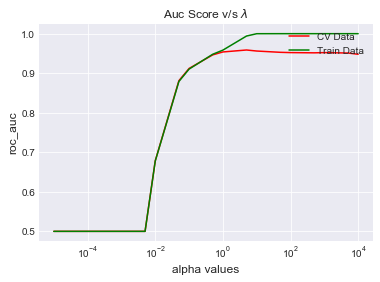

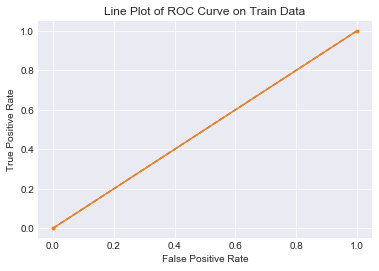

In [42]:
# find optimal_C using l1 regularization
logistic_l1(tfidf_train,tfidf_cv,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.9620461544404055  and for train data auc score is -->  0.9999999988606081
5000  for CV data auc score is -->  0.9623224745018848  and for train data auc score is -->  0.9999999988606079
1000  for CV data auc score is -->  0.962310496906911  and for train data auc score is -->  0.9999999988606079
500  for CV data auc score is -->  0.9624508657116853  and for train data auc score is -->  0.9999999988606079
100  for CV data auc score is -->  0.9626415677213035  and for train data auc score is -->  0.9999999988606079
50  for CV data auc score is -->  0.9627274287498786  and for train data auc score is -->  0.9999999988606079
10  for CV data auc score is -->  0.9625154257816566  and for train data auc score is -->  0.9999464519907374
5  for CV data auc score is -->  0.9618498662804267  and for train data auc score is -->  0.9990413753277217
1  for CV data auc score is -->  0.9564004007347837  and for train data auc score is -->  0.9839091912402279
0.5 

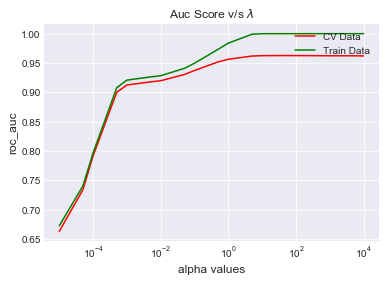

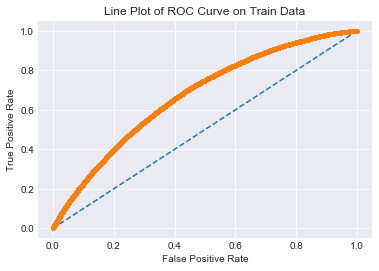

In [43]:
# find optimal_C using l2 regularization
logistic_l2(tfidf_train,tfidf_cv,Y_tr,Y_cv)

###  Logistic Regression Over the unseen or Test data in TF-IDF

AUC Score 0.9588670935471677
macro f1 score for data : 0.8627215526500356
micro f1 scoore for data: 0.9302089241822651
hamming loss for data: 0.06979107581773492
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77     13407
           1       0.95      0.97      0.96     71217

   micro avg       0.93      0.93      0.93     84624
   macro avg       0.88      0.85      0.86     84624
weighted avg       0.93      0.93      0.93     84624



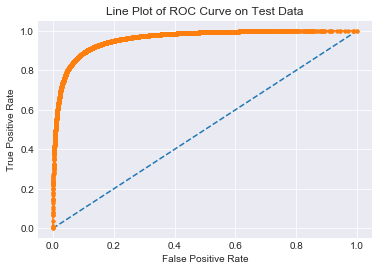

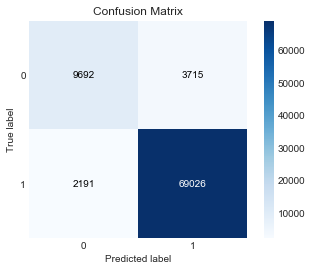

In [44]:
testing_l1(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_C=5)

AUC Score 0.9623107060731548
macro f1 score for data : 0.8649699182117649
micro f1 scoore for data: 0.9331631688409907
hamming loss for data: 0.06683683115900926
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77     13407
           1       0.95      0.98      0.96     71217

   micro avg       0.93      0.93      0.93     84624
   macro avg       0.90      0.84      0.86     84624
weighted avg       0.93      0.93      0.93     84624



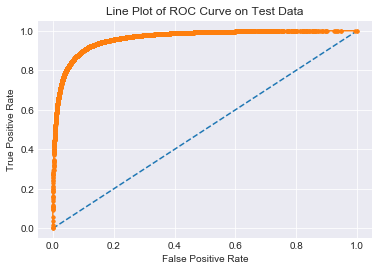

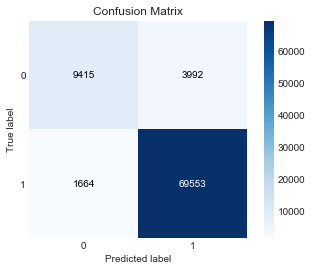

In [45]:
testing_l2(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_C=50)

In [46]:
clf1=LogisticRegression(penalty='l1',C=5)
clf1.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf1)

			Negative						Positive
________________________________________________________________________________________________
	-54.5735	two star       				34.8736	pleasant surpris
	-29.7651	worst          				33.5165	great          
	-26.2039	disappoint     				31.4493	high recommend 
	-25.9299	decent use     				31.1902	delici         
	-24.6044	least favorit  				28.2384	four star      
	-22.9339	terribl        				27.0996	perfect        
	-22.2055	cannot recommend				26.5241	wont disappoint
	-21.6708	undrink        				26.1000	best           
	-21.6333	oat roll       				25.9049	excel          
	-21.6265	can sever      				24.0695	love           


In [47]:
clf2=LogisticRegression(penalty='l2',C=50)
clf2.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf2)

			Negative						Positive
________________________________________________________________________________________________
	-28.3874	disappoint     				31.6732	great          
	-26.6740	worst          				27.3465	delici         
	-22.2637	terribl        				25.1577	best           
	-19.9733	aw             				24.0328	perfect        
	-19.6164	horribl        				23.9598	love           
	-18.2742	return         				21.7541	excel          
	-17.9923	two star       				20.1395	high recommend 
	-16.6708	unfortun       				18.8025	nice           
	-16.1234	disgust        				17.6408	good           
	-15.7882	stale          				17.2816	amaz           


## Avg W2V

In [48]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [49]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [50]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [51]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [52]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [53]:
train_avgw2v = avg_w2v(list_of_sent_train)

115114
50


In [54]:
cv_avgw2v = avg_w2v(list_of_sent_CV)

56698
50


In [55]:
test_avgw2v = avg_w2v(list_of_sent_test)

84624
50


In [56]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

10000  for CV data auc score is -->  0.9137147259828023  and for train data auc score is -->  0.9122094322904706
5000  for CV data auc score is -->  0.9137150754064579  and for train data auc score is -->  0.9122061451443395
1000  for CV data auc score is -->  0.9137144297826174  and for train data auc score is -->  0.9122096909324713
500  for CV data auc score is -->  0.9137144598654487  and for train data auc score is -->  0.9122089890669542
100  for CV data auc score is -->  0.9137148139172322  and for train data auc score is -->  0.9122092944240299
50  for CV data auc score is -->  0.913714869454767  and for train data auc score is -->  0.912209482993418
10  for CV data auc score is -->  0.913716970624828  and for train data auc score is -->  0.9122108815971877
5  for CV data auc score is -->  0.9137182248474857  and for train data auc score is -->  0.9122124568067288
1  for CV data auc score is -->  0.9137381558802345  and for train data auc score is -->  0.9122195734496179
0.5  f

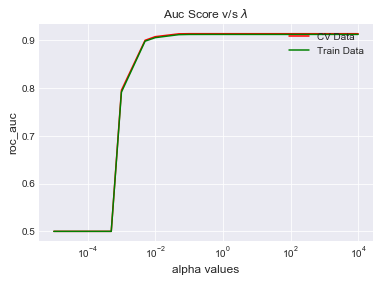

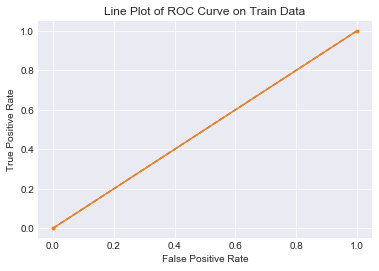

In [57]:
# find optimal_C using l1 regularization
logistic_l1(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.9137159917757798  and for train data auc score is -->  0.9122085754676316
5000  for CV data auc score is -->  0.9137159987179717  and for train data auc score is -->  0.912208580594896
1000  for CV data auc score is -->  0.9137160866524014  and for train data auc score is -->  0.9122086090796979
500  for CV data auc score is -->  0.9137160935945932  and for train data auc score is -->  0.9122086797220065
100  for CV data auc score is -->  0.9137167831856485  and for train data auc score is -->  0.9122090095760115
50  for CV data auc score is -->  0.9137174195532332  and for train data auc score is -->  0.9122096123144183
10  for CV data auc score is -->  0.9137219551185631  and for train data auc score is -->  0.9122136605744542
5  for CV data auc score is -->  0.9137268586200604  and for train data auc score is -->  0.9122187120692106
1  for CV data auc score is -->  0.9137678314362513  and for train data auc score is -->  0.9122488672198191
0.5 

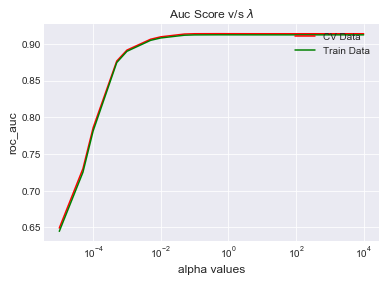

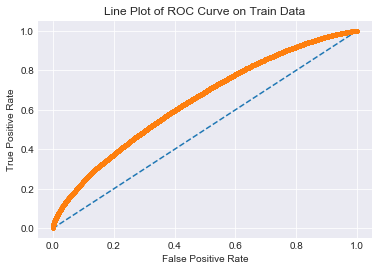

In [58]:
# find optimal_C using l2 regularization
logistic_l2(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

AUC Score 0.9131383534549062
macro f1 score for data : 0.7746668684119387
micro f1 scoore for data: 0.8952897523161278
hamming loss for data: 0.10471024768387219
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.74      0.52      0.61     13407
           1       0.91      0.97      0.94     71217

   micro avg       0.90      0.90      0.90     84624
   macro avg       0.83      0.74      0.77     84624
weighted avg       0.89      0.90      0.89     84624



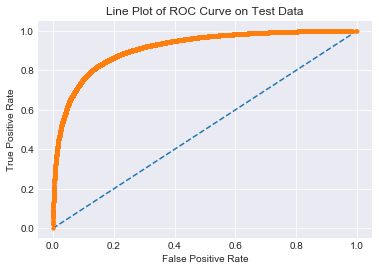

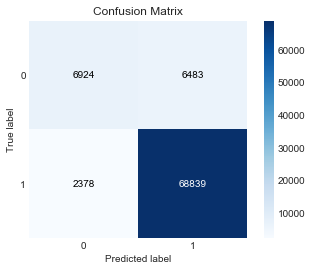

In [59]:
testing_l1(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_C=0.5)

AUC Score 0.9132104570832862
macro f1 score for data : 0.7736040913603216
micro f1 scoore for data: 0.895266118358858
hamming loss for data: 0.10473388164114199
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.75      0.51      0.61     13407
           1       0.91      0.97      0.94     71217

   micro avg       0.90      0.90      0.90     84624
   macro avg       0.83      0.74      0.77     84624
weighted avg       0.89      0.90      0.89     84624



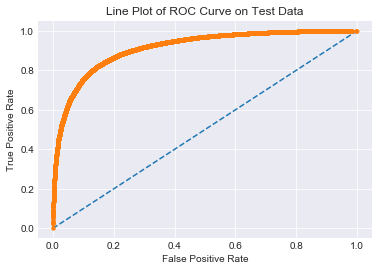

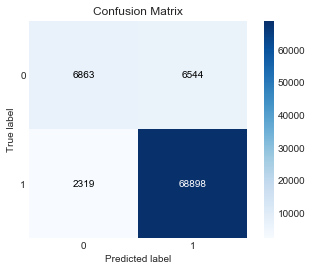

In [60]:
testing_l2(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_C=0.5)

## TF-IDF Weighted W2V

In [66]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (115114, 40518)
CV Data Size:  (56698, 40518)
Test Data Size:  (84624, 40518)


In [71]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
#return tfidf_sent_vectors_train

115114
50


In [72]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
#return tfidf_sent_vectors_CV

56698
50


In [73]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
#return tfidf_sent_vectors_test

84624
50


In [75]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [79]:
normalizer = preprocessing.Normalizer()
train_tfidfw2v = normalizer.fit_transform(train_tfidfw2v)
cv_tfidfw2v = normalizer.transform(cv_tfidfw2v)
test_tfidfw2v = normalizer.transform(test_tfidfw2v)

10000  for CV data auc score is -->  0.8878792526339879  and for train data auc score is -->  0.8865923071218754
5000  for CV data auc score is -->  0.8878794608997429  and for train data auc score is -->  0.8865927469272157
1000  for CV data auc score is -->  0.8878768413793583  and for train data auc score is -->  0.8865885750431397
500  for CV data auc score is -->  0.8878792688324355  and for train data auc score is -->  0.8865926170365193
100  for CV data auc score is -->  0.8878796460248582  and for train data auc score is -->  0.8865925395578583
50  for CV data auc score is -->  0.887879537263853  and for train data auc score is -->  0.8865931457144411
10  for CV data auc score is -->  0.8878812473571075  and for train data auc score is -->  0.8865953339169178
5  for CV data auc score is -->  0.8878823511656089  and for train data auc score is -->  0.8865974258407642
1  for CV data auc score is -->  0.8878921026310684  and for train data auc score is -->  0.8866155102717495
0.5 

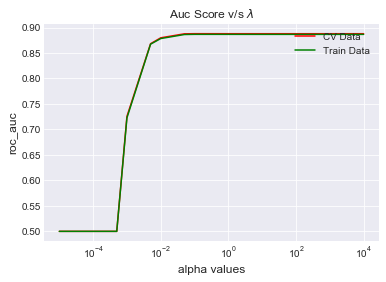

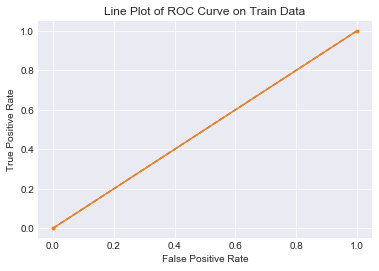

In [80]:
# find optimal_C using l1 regularization
logistic_l1(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.8878793822215688  and for train data auc score is -->  0.8865907484335194
5000  for CV data auc score is -->  0.8878795280075973  and for train data auc score is -->  0.8865907866031537
1000  for CV data auc score is -->  0.8878795303216612  and for train data auc score is -->  0.8865908031243389
500  for CV data auc score is -->  0.8878796251982828  and for train data auc score is -->  0.8865908674999909
100  for CV data auc score is -->  0.8878799861922582  and for train data auc score is -->  0.8865913238265164
50  for CV data auc score is -->  0.8878805739644999  and for train data auc score is -->  0.8865919772678703
10  for CV data auc score is -->  0.8878840589447994  and for train data auc score is -->  0.8865967171388947
5  for CV data auc score is -->  0.887887335659344  and for train data auc score is -->  0.886601549870373
1  for CV data auc score is -->  0.8879141394620065  and for train data auc score is -->  0.886639702983639
0.5  f

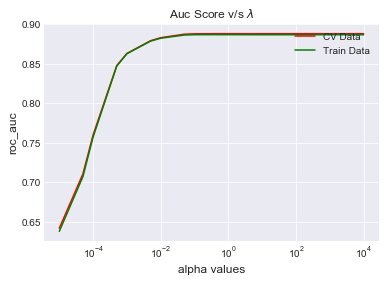

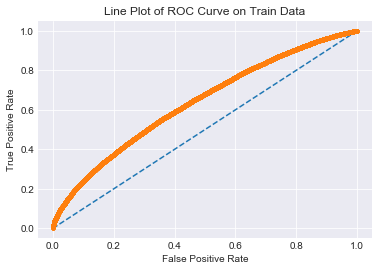

In [81]:
# find optimal_C using l1 regularization
logistic_l2(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

AUC Score 0.8872233092123054
macro f1 score for data : 0.7276069252646076
micro f1 scoore for data: 0.8814757042919268
hamming loss for data: 0.11852429570807337
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.72      0.41      0.52     13407
           1       0.90      0.97      0.93     71217

   micro avg       0.88      0.88      0.88     84624
   macro avg       0.81      0.69      0.73     84624
weighted avg       0.87      0.88      0.87     84624



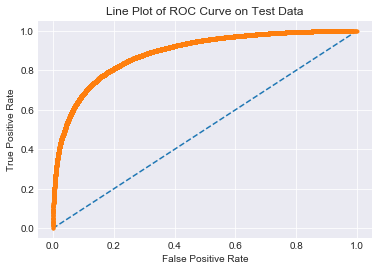

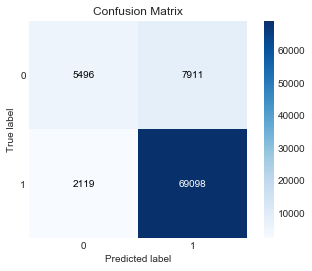

In [82]:
testing_l1(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_C=0.1)

AUC Score 0.8873407204587216
macro f1 score for data : 0.7298904011937353
micro f1 scoore for data: 0.8818892985441482
hamming loss for data: 0.11811070145585177
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.72      0.42      0.53     13407
           1       0.90      0.97      0.93     71217

   micro avg       0.88      0.88      0.88     84624
   macro avg       0.81      0.69      0.73     84624
weighted avg       0.87      0.88      0.87     84624



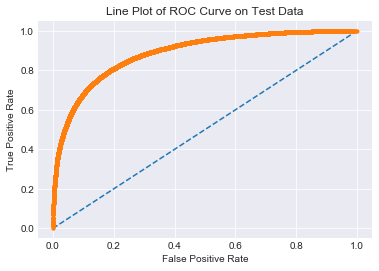

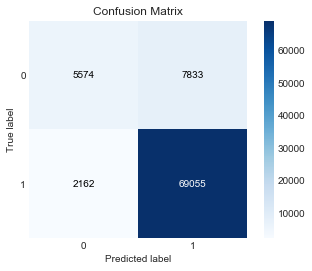

In [83]:
testing_l2(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_C=0.5)

In [84]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Regularization", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","L1",5,94.84])
x.add_row(["BoW","L2",5,95.02])
x.add_row(["Tf-Idf","L1",5,95.88])
x.add_row(["Tf-Idf","L2",50,96.23])
x.add_row(["Avg-W2V","L1",0.5,91.31])
x.add_row(["Avg-W2V","L2",0.5,91.32])
x.add_row(["TfIdf-W2V","L1",0.1,88.72])
x.add_row(["TfIdf-W2V","L2",0.5,88.73])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+----------------+-------------------------+----------------+
| Vectorizer | Regularization | Best Hyper Parameter(C) | Test Auc Score |
+------------+----------------+-------------------------+----------------+
|    BoW     |       L1       |            5            |     94.84      |
|    BoW     |       L2       |            5            |     95.02      |
|   Tf-Idf   |       L1       |            5            |     95.88      |
|   Tf-Idf   |       L2       |            50           |     96.23      |
|  Avg-W2V   |       L1       |           0.5           |     91.31      |
|  Avg-W2V   |       L2       |           0.5           |     91.32      |
| TfIdf-W2V  |       L1       |           0.1           |     88.72      |
| TfIdf-W2V  |       L2       |           0.5           |     88.73      |
+------------+----------------+-------------------------+----------------+
